# UNet segmentation from few annotations

This notebook was originaly developed to work on DTU D-bar cluster in connection with the course 02510, and is strongly based on UNet notebook prepared by Patrick Jensen for the same course. This particular version has been adapted, such that it also can be run from google colab.

## Running it on G-bar
If you are want to run the notebooke on DTU G-bar *a one way* to achive it is: 

* Log on G-bar using ThinLinc client
* Copy the notebook to a folder you have access to
* Open the terminal (Applications -> System -> Terminal)
* Start course node `02510sh -X`
* Navigate to `/dtu/3d-imaging-center/courses`
* Launch initialization script `conda/conda-init.sh`
* Activate the environment `conda activate env-02510`
* Navigate to the folder where you placed the notebook
* Start notebook `jupyter-notebook`

Furthermore, if you are at DTU G-bar, you don't need to retrieve the data, instead use data in following directories:
```
ANNOTATIONS_ROOT = '/dtu/3d-imaging-center/courses/02510/groups/group11/Part02/'
SLICES_ROOT = '/dtu/3d-imaging-center/courses/02510/data/Nerve/NT2_crop_slices/'
```

Also, `monai` is installed in environment `env-02510` so you don't need to install it.



## Running it on google colab
If you are running this on google colab, you can change the runtime by choosing in the colab menu
```
Runtime -> Change run time type -> GPU,TPU
```

In [ ]:
# Retrieve volume from QIM data repository.
!wget -q https://qim.compute.dtu.dk/data-repository/nerves_data.zip

# Unzip the file to the current directory
import shutil
shutil.unpack_archive('nerves_data.zip', 'nerves_data')

## Inspect the Data

In [26]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import torch
import torch.nn as nn
from tqdm import tqdm, trange

from matplotlib.colors import ListedColormap

In [27]:
# Load images and annotations.
SLICES_ROOT = 'nerves_data/NT2_crop_slices/'
ANNOTATIONS_ROOT = 'nerves_data/annotations/Part02/'
base_image_name = '02_annotation_slice_' # For part 2
# base_image_name = '03_annotation_slice_' # For part 3
# base_image_name = '04_annotation_slice_' # For part 4

annotated_slices = [int(s[-7:-4]) for s in sorted(glob(ANNOTATIONS_ROOT + '*.png'))]  

annotated_images_filenames = [SLICES_ROOT + f'slice_{n:03}.tif' for n in annotated_slices]
annotations_filenames = [ANNOTATIONS_ROOT + f'{base_image_name}{n:03}.png' for n in annotated_slices]

# Use following lines to load 3 slices per annotation.
annotated_images_filenames = [SLICES_ROOT + f'slice_{n:03}.tif' for n in annotated_slices 
                              for j in [-1, 0, 1]]
annotations_filenames = [ANNOTATIONS_ROOT + f'{base_image_name}{n:03}.png' for n in annotated_slices 
                         for j in [0, 0, 0]]

labeled_images = [imread(f).astype('float32') / 255.0 for f in tqdm(annotated_images_filenames)]  
labels = [imread(f) for f in tqdm(annotations_filenames)] 

# transforming rgb images to label images
labels = [np.unique(l.reshape(-1, 4), axis=0, return_inverse=True)[1].reshape(l.shape[:2]) for l in labels]

all_image_filenames = sorted(glob(SLICES_ROOT + 'slice_*.tif'))
all_images = [imread(f).astype('float32') / 255.0 for f in tqdm(all_image_filenames)]  


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 662.22it/s]


In [28]:
# Check that all annotations are consistent.

for l in labels:
    assert l.max()==2, "all label images should have 3 unique colors"

# For partial annotations use followint:
# for l in labels:
#    assert l.max()==3, "all label images should have 4 unique colors"



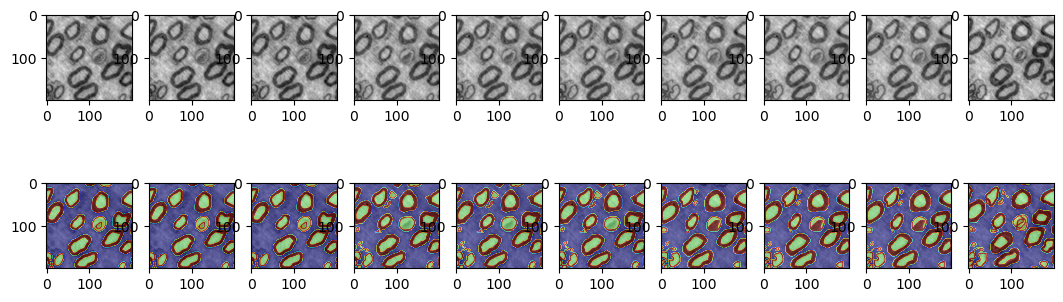

In [29]:
# Show labeled (annotated) images.

num_images = min(10, len(labeled_images))

fig, axes = plt.subplots(2, num_images, figsize=(13, 4))
[axes[j, i].imshow(labeled_images[i], cmap='gray') for i in range(num_images) for j in range(2)]
[axes[1, i].imshow(labels[i], cmap='jet', alpha=0.5) for i in range(num_images)]
plt.show()

# Train a U-Net



In [ ]:
# Figure out whether to use cpu or cuda.

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
else:
    device = torch.device('cpu')
    print('Using cpu')

In [30]:
!pip install monai
from monai.networks.nets import UNet
from monai.data import ArrayDataset
from torch.utils.data import DataLoader

In [31]:
# Define a model.

model = UNet(
    spatial_dims=2, 
    in_channels=1,   
    out_channels=3,  
    channels=(4, 8, 16),      
    strides=(2, 2),       
)

orig_state = model.state_dict()  # Save, so we can reset model to original state later

In [32]:
# Make dataset and dataloader.

labeled_images_torch = [2 * torch.from_numpy(x).unsqueeze(0).float() - 1 for x in labeled_images]
labels_torch = [torch.from_numpy(x).long() for x in labels]

train_data = ArrayDataset(img=labeled_images_torch, seg=labels_torch)
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)


In [33]:
# Train.

NUM_EPOCHS = 100
LR = 3e-3

model.load_state_dict(orig_state)  # Restart training every time
model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

all_losses = []

tr = trange(NUM_EPOCHS)
for epoch in tr:
    
    model.train()
    epoch_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        # For a partial annotation where 0 is blank and labels are from 1 to 3 
        # use following loss:
        # loss = loss_fn(outputs * (targets > 0), (targets - 1) * (targets > 0))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach()
    
    mean_epoch_loss = epoch_loss.item()/len(train_loader)
    all_losses.append(mean_epoch_loss)
    tr.set_description(f'Loss {mean_epoch_loss}')


Loss 0.2798460073638381: 100%|████████████████| 100/100 [01:00<00:00,  1.64it/s]


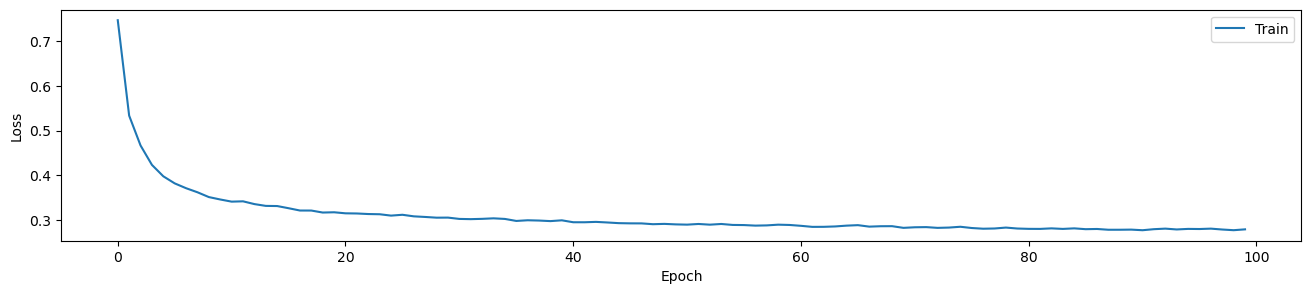

In [34]:
# Visualize training process.

plt.figure(figsize=(16, 3))
plt.plot(all_losses, '-', label='Train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Inspecting the Predicted Segmentations



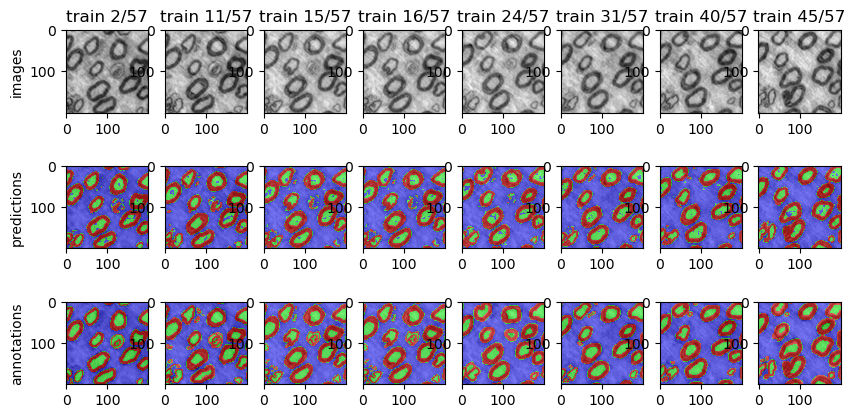

In [35]:
# Show the result on a random subset of training data.

num_images = min(8, len(train_data))
indices = sorted(np.random.choice(np.arange(len(train_data)), num_images, replace=False))
model.eval()

# define colormap 
rgbcmap = ListedColormap(np.array([[0,0,1.,1.], [0,1.,0,1.], [1.,0,0,1.]]))

fig, axes = plt.subplots(3, num_images, figsize=(10, 5))

for i in range(num_images):
    
    im, lb = train_data[indices[i]]
    [axes[j, i].imshow(im[0], cmap='gray') for j in range(3)]

    with torch.no_grad():
        pred = model(im.unsqueeze(0).cuda())
    pred = pred.cpu().numpy()[0].argmax(axis=0)
    
    axes[1, i].imshow(pred, cmap=rgbcmap, alpha=0.5)
    # For comparison with parital annotation modify how predictions are shown:
    # axes[1, i].imshow(pred + 1, vmin=0, cmap='viridis', alpha=0.5)
    axes[2, i].imshow(lb, cmap=rgbcmap, alpha=0.5)
    axes[0, i].set_title(f'train {indices[i]}/{len(train_data)}')
    
axes[0, 0].set_ylabel('images')
axes[1, 0].set_ylabel('predictions')
axes[2, 0].set_ylabel('annotations')
plt.show()


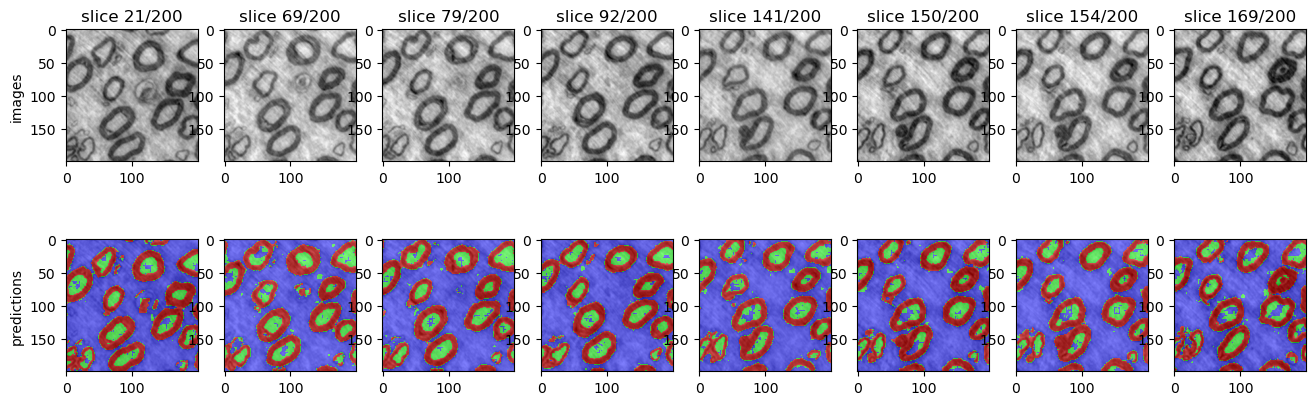

In [36]:
# Show the result on a random subset of all images.

num_images = min(8, len(all_images))

indices = sorted(np.random.choice(np.arange(len(all_images)), num_images, replace=False))
model.eval()

fig, axes = plt.subplots(2, num_images, figsize=(16, 5))
for i in range(num_images):
    
    im = all_images[indices[i]]
    [axes[j, i].imshow(im, cmap='gray') for j in range(2)]

    im_input = (2 * torch.from_numpy(im) - 1).unsqueeze(0).unsqueeze(0).float().cuda()
    with torch.no_grad():
        pred = model(im_input)
    pred = pred.cpu().numpy()[0].argmax(axis=0)
    
    axes[1, i].imshow(pred, cmap=rgbcmap, alpha=0.5)
    axes[0, i].set_title(f'slice {indices[i]}/{len(all_images)}')
    
axes[0, 0].set_ylabel('images')
axes[1, 0].set_ylabel('predictions')
plt.show()

In [25]:
# Predict segmentation for all slices.

segmentation = []

for im in all_images:
    im_input = (2 * torch.from_numpy(im) - 1).unsqueeze(0).unsqueeze(0).float().cuda()
    with torch.no_grad():
        pred = model(im_input)
    pred = pred.cpu().numpy()[0].argmax(axis=0)
    segmentation.append(pred)
    
segmentation = np.stack(segmentation)


In [45]:
# Save segmented volumes.

import tifffile
tifffile.imwrite('02_class_0.tiff', 127*segmentation.astype(np.uint8))
tifffile.imwrite('02_class_1.tiff', 255*(segmentation==1).astype(np.uint8))
tifffile.imwrite('02_class_2.tiff', 255*(segmentation==2).astype(np.uint8))